In [1]:
# Coca-Cola vs. Pepsi - Kilpailija-analyysi
# Vertailu 1.1.2020 alkaen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Matplotlib-asetukset
plt.rcParams['font.size'] = 12
plt.rcParams['figure.facecolor'] = 'white'
try:
    sns.set_style("whitegrid")
    sns.set_palette("husl")
except:
    plt.style.use('ggplot')

# Yfinance-kirjasto
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
    print("✅ yfinance saatavilla - haetaan todellista dataa")
except ImportError:
    YFINANCE_AVAILABLE = False
    print("⚠️  yfinance ei saatavilla - käytetään simuloitua dataa")
    print("💡 Asenna: pip install yfinance")

def get_stock_data(tickers=['KO', 'PEP']):
    """
    Hae osakedata molemmille yhtiöille
    """
    start_date = '2020-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')
    
    if YFINANCE_AVAILABLE:
        try:
            print("📊 Haetaan todellista dataa...")
            data = {}
            
            for ticker in tickers:
                stock = yf.Ticker(ticker)
                hist = stock.history(start=start_date, end=end_date)
                
                if not hist.empty:
                    data[ticker] = hist['Close']
                    company_name = "Coca-Cola" if ticker == "KO" else "PepsiCo"
                    print(f"   {company_name} ({ticker}): {len(hist)} päivää")
                else:
                    raise Exception(f"Ei dataa ticker {ticker}")
            
            # Yhdistä data
            combined_data = pd.DataFrame(data)
            combined_data = combined_data.dropna()
            
            print(f"✅ Todellinen data haettu: {combined_data.index[0].strftime('%Y-%m-%d')} - {combined_data.index[-1].strftime('%Y-%m-%d')}")
            return combined_data
            
        except Exception as e:
            print(f"❌ Virhe: {e}")
            print("📊 Siirrytään simuloituun dataan")
    
    # Simuloi realistinen data
    print("📊 Generoidaan simuloitu data...")

    np.random.seed(42)
    start = datetime(2020, 1, 1)
    end = datetime.now()
    business_days = pd.bdate_range(start=start, end=end)
    n_days = len(business_days)
    
    # Realistiset parametrit kilpailijoille
    companies = {
        'KO': {  # Coca-Cola
            'name': 'Coca-Cola',
            'annual_return': 0.06,   # 6% vuosituotto
            'volatility': 0.18,      # 18% volatiliteetti
            'initial_price': 55.0,   # Tammikuu 2020 hinta
            'beta': 0.75,            # Matala beta (defensive)
            'sector_correlation': 0.7 # Korrelaatio Pepsin kanssa
        },
        'PEP': {  # PepsiCo
            'name': 'PepsiCo',
            'annual_return': 0.07,   # 7% vuosituotto (hieman parempi diversifikaatio)
            'volatility': 0.16,      # 16% volatiliteetti (hieman vähemmän)
            'initial_price': 137.0,  # Tammikuu 2020 hinta
            'beta': 0.65,            # Matala beta
            'sector_correlation': 0.7
        }
    }
 # Generoi markkinashokki (yhteinen tekijä)
    market_shocks = np.random.normal(0, 0.15/np.sqrt(252), n_days)
    
    data = {}
    
    for ticker, params in companies.items():
        # Yrityskohtaiset shokitt
        idiosync_vol = np.sqrt(params['volatility']**2 - (params['beta'] * 0.15)**2)
        idiosync_shocks = np.random.normal(0, idiosync_vol/np.sqrt(252), n_days)
        
        # Sektorikorrelaatio (lisää samankaltaisuutta)
        if ticker == 'PEP':
            correlation_factor = 0.3  # Osa shokeista on samoja
            sector_shocks = correlation_factor * data['KO'].pct_change().fillna(0).values[-n_days:] if 'KO' in data else np.zeros(n_days)
        else:
            sector_shocks = np.zeros(n_days)
        
        # Kokonaistuotot
        daily_drift = params['annual_return'] / 252
        daily_returns = (daily_drift + 
                        params['beta'] * market_shocks + 
                        idiosync_shocks + 
                        sector_shocks)
        
        # COVID-19 vaikutus (molemmille samankaltainen)
        covid_mask = (business_days >= '2020-02-20') & (business_days <= '2020-05-01')
        daily_returns[covid_mask] += np.random.normal(-0.001, 0.002, covid_mask.sum())
        
        # Inflaatiovaikutus 2021-2022 (kulutustavaroille)
        inflation_mask = (business_days >= '2021-06-01') & (business_days <= '2022-12-31')
        daily_returns[inflation_mask] += np.random.normal(0.0002, 0.001, inflation_mask.sum())
        
        # Laske hinnat
        prices = params['initial_price'] * np.cumprod(1 + daily_returns)
        data[ticker] = pd.Series(prices, index=business_days)
    
    combined_data = pd.DataFrame(data)
    print(f"✅ Simuloitu data: {combined_data.index[0].strftime('%Y-%m-%d')} - {combined_data.index[-1].strftime('%Y-%m-%d')}")
    
    return combined_data

✅ yfinance saatavilla - haetaan todellista dataa


In [3]:
def calculate_comparative_metrics(data):
    """
    Laske vertailumittareita
    """
    results = {}
    
    for ticker in data.columns:
        prices = data[ticker]
        returns = prices.pct_change().dropna()
        
        # Perusmittarit
        total_return = (prices.iloc[-1] / prices.iloc[0] - 1) * 100
        years = len(prices) / 252
        annualized_return = ((prices.iloc[-1] / prices.iloc[0]) ** (1/years) - 1) * 100
        annualized_vol = returns.std() * np.sqrt(252) * 100
        
        # Sharpe-suhde (2% riskitön korko)
        sharpe = (annualized_return - 2.0) / annualized_vol
        
        # Drawdown
        cummax = prices.expanding().max()
        drawdown = (prices / cummax - 1) * 100
        max_drawdown = drawdown.min()
        
        # Sortino-suhde (vain negatiiviset tuotot)
        negative_returns = returns[returns < 0]
        downside_vol = negative_returns.std() * np.sqrt(252) * 100 if len(negative_returns) > 0 else 0
        sortino = (annualized_return - 2.0) / downside_vol if downside_vol > 0 else np.inf
        
        # Positiivisten päivien osuus
        win_rate = (returns > 0).mean() * 100
        
        # Volatiliteetin keskiarvo eri jaksoilla
        vol_2020 = returns[returns.index.year == 2020].std() * np.sqrt(252) * 100
        vol_2021 = returns[returns.index.year == 2021].std() * np.sqrt(252) * 100
        vol_2022 = returns[returns.index.year == 2022].std() * np.sqrt(252) * 100
        vol_recent = returns.tail(90).std() * np.sqrt(252) * 100
        
        results[ticker] = {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': annualized_vol,
            'sharpe': sharpe,
            'sortino': sortino,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'vol_2020': vol_2020,
            'vol_2021': vol_2021,
            'vol_2022': vol_2022,
            'vol_recent': vol_recent,
            'years': years
        }
    
    return results

In [4]:
def calculate_correlation_analysis(data):
    """
    Analysoi korrelaatioita
    """
    returns = data.pct_change().dropna()
    
    # Korrelaatio
    correlation = returns.corr().iloc[0, 1]
    
    # Rolling correlation
    rolling_corr = returns['KO'].rolling(window=60).corr(returns['PEP'])
    
    # Beta (Pepsi vs. Coca-Cola)
    ko_returns = returns['KO']
    pep_returns = returns['PEP']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ko_returns, pep_returns)
    
    return {
        'correlation': correlation,
        'rolling_correlation': rolling_corr,
        'beta_pep_vs_ko': slope,
        'alpha_pep_vs_ko': intercept * 252,  # Vuositettu
        'r_squared': r_value**2
    }

In [5]:
def analyze_relative_performance(data):
    """
    Analysoi suhteellista suoriutumista
    """
    # Normalisoi molemmat sarjat alkuarvoon 100
    normalized = data.div(data.iloc[0]) * 100
    
    # Suhteellinen vahvuus (Pepsi / Coca-Cola)
    relative_strength = data['PEP'] / data['KO']
    relative_strength_norm = relative_strength / relative_strength.iloc[0] * 100
    
    # Spread (ero normalisoiduissa tuotoissa)
    spread = normalized['PEP'] - normalized['KO']
    
    return {
        'normalized_prices': normalized,
        'relative_strength': relative_strength_norm,
        'spread': spread
    }

In [6]:
# PÄÄANALYYSI
print("🥤🆚🥤 COCA-COLA vs. PEPSI - KILPAILIJA-ANALYYSI")
print("=" * 65)
print("Vertaillaan kahden virvoitusjättin suoriutumista 1.1.2020 alkaen\n")

# 1. DATAN HAKU
print("📊 1. DATAN HAKU JA PERUSANALYYSI")
print("-" * 50)

stock_data = get_stock_data(['KO', 'PEP'])

# Lisää yritysnimet
company_names = {'KO': 'Coca-Cola', 'PEP': 'PepsiCo'}

print(f"\nDATA-YHTEENVETO:")
for ticker in stock_data.columns:
    initial_price = stock_data[ticker].iloc[0]
    final_price = stock_data[ticker].iloc[-1]
    total_return = (final_price / initial_price - 1) * 100
    print(f"• {company_names[ticker]} ({ticker}): ${initial_price:.2f} → ${final_price:.2f} ({total_return:+.1f}%)")

🥤🆚🥤 COCA-COLA vs. PEPSI - KILPAILIJA-ANALYYSI
Vertaillaan kahden virvoitusjättin suoriutumista 1.1.2020 alkaen

📊 1. DATAN HAKU JA PERUSANALYYSI
--------------------------------------------------
📊 Haetaan todellista dataa...
   Coca-Cola (KO): 1388 päivää
   PepsiCo (PEP): 1388 päivää
✅ Todellinen data haettu: 2020-01-02 - 2025-07-11

DATA-YHTEENVETO:
• Coca-Cola (KO): $46.42 → $69.87 (+50.5%)
• PepsiCo (PEP): $115.34 → $135.26 (+17.3%)


In [7]:
# 2. MITTAREIDEN LASKENTA
metrics = calculate_comparative_metrics(stock_data)
correlation_data = calculate_correlation_analysis(stock_data)
relative_analysis = analyze_relative_performance(stock_data)

print(f"\n📊 2. VERTAILUMITTARIT")
print("-" * 50)

# Luo vertailutaulukko
comparison_df = pd.DataFrame({
    'Mittari': [
        'Kokonaistuotto (%)',
        'Vuositettu tuotto (%)',
        'Volatiliteetti (%)',
        'Sharpe-suhde',
        'Sortino-suhde',
        'Maksimi drawdown (%)',
        'Voittoprosentti (%)'
    ],
    'Coca-Cola (KO)': [
        f"{metrics['KO']['total_return']:.1f}",
        f"{metrics['KO']['annualized_return']:.1f}",
        f"{metrics['KO']['volatility']:.1f}",
        f"{metrics['KO']['sharpe']:.2f}",
        f"{metrics['KO']['sortino']:.2f}",
        f"{metrics['KO']['max_drawdown']:.1f}",
        f"{metrics['KO']['win_rate']:.1f}"
    ],
    'PepsiCo (PEP)': [
        f"{metrics['PEP']['total_return']:.1f}",
        f"{metrics['PEP']['annualized_return']:.1f}",
        f"{metrics['PEP']['volatility']:.1f}",
        f"{metrics['PEP']['sharpe']:.2f}",
        f"{metrics['PEP']['sortino']:.2f}",
        f"{metrics['PEP']['max_drawdown']:.1f}",
        f"{metrics['PEP']['win_rate']:.1f}"
    ]
})

print(comparison_df.to_string(index=False))

print(f"\nKORRELAATIOANALYYSI:")
print(f"• Korrelaatio: {correlation_data['correlation']:.3f}")
print(f"• Pepsi vs. Coca-Cola beta: {correlation_data['beta_pep_vs_ko']:.3f}")
print(f"• Pepsi vs. Coca-Cola alpha: {correlation_data['alpha_pep_vs_ko']:.2f}%")
print(f"• R²: {correlation_data['r_squared']:.3f}")


📊 2. VERTAILUMITTARIT
--------------------------------------------------
              Mittari Coca-Cola (KO) PepsiCo (PEP)
   Kokonaistuotto (%)           50.5          17.3
Vuositettu tuotto (%)            7.7           2.9
   Volatiliteetti (%)           20.7          22.1
         Sharpe-suhde           0.28          0.04
        Sortino-suhde           0.34          0.05
 Maksimi drawdown (%)          -37.0         -30.3
  Voittoprosentti (%)           53.4          52.8

KORRELAATIOANALYYSI:
• Korrelaatio: 0.744
• Pepsi vs. Coca-Cola beta: 0.796
• Pepsi vs. Coca-Cola alpha: -0.02%
• R²: 0.554



📊 3. VISUAALINEN ANALYYSI
--------------------------------------------------


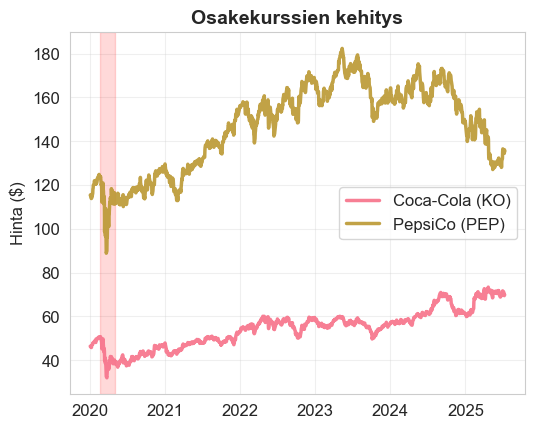

In [8]:
# 3. VISUALISOINTI
print(f"\n📊 3. VISUAALINEN ANALYYSI")
print("-" * 50)

fig = plt.figure(figsize=(20, 16))

# 1. Hintojen kehitys
ax1 = plt.subplot(3, 3, 1)
for ticker in stock_data.columns:
    ax1.plot(stock_data.index, stock_data[ticker], linewidth=2.5, 
             label=f"{company_names[ticker]} ({ticker})", alpha=0.9)

ax1.set_title('Osakekurssien kehitys', fontsize=14, fontweight='bold')
ax1.set_ylabel('Hinta ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# COVID-19 merkintä
covid_start, covid_end = datetime(2020, 2, 20), datetime(2020, 5, 1)
ax1.axvspan(covid_start, covid_end, alpha=0.15, color='red', label='COVID-19')

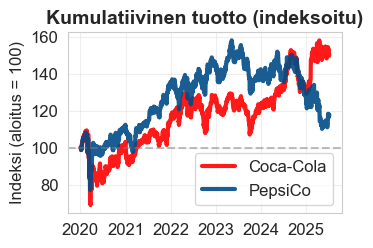

In [20]:
# 2. Normalisoidut tuotot (indeksoitu 100:aan)
plt.figure(figsize=(12, 8))
ax2 = plt.subplot(3, 3, 2)
normalized = relative_analysis['normalized_prices']
colors = ['#FF0000', '#004B87']  # Coca-Cola punainen, Pepsi sininen

for i, ticker in enumerate(normalized.columns):
    ax2.plot(normalized.index, normalized[ticker], linewidth=3, 
             color=colors[i], label=f"{company_names[ticker]}", alpha=0.9)

ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Kumulatiivinen tuotto (indeksoitu)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Indeksi (aloitus = 100)')
ax2.legend()
ax2.grid(True, alpha=0.3)

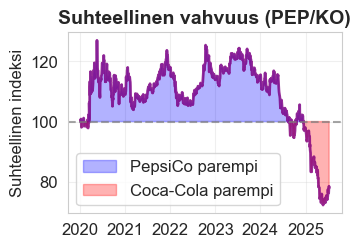

In [21]:
# 3. Suhteellinen vahvuus (Pepsi / Coca-Cola)
plt.figure(figsize=(12, 8))
ax3 = plt.subplot(3, 3, 3)
rel_strength = relative_analysis['relative_strength']
ax3.plot(rel_strength.index, rel_strength, linewidth=2, color='purple', alpha=0.8)
ax3.axhline(y=100, color='gray', linestyle='--', alpha=0.7)
ax3.fill_between(rel_strength.index, rel_strength, 100, 
                 where=(rel_strength >= 100), alpha=0.3, color='blue', label='PepsiCo parempi')
ax3.fill_between(rel_strength.index, rel_strength, 100, 
                 where=(rel_strength < 100), alpha=0.3, color='red', label='Coca-Cola parempi')

ax3.set_title('Suhteellinen vahvuus (PEP/KO)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Suhteellinen indeksi')
ax3.legend()
ax3.grid(True, alpha=0.3)

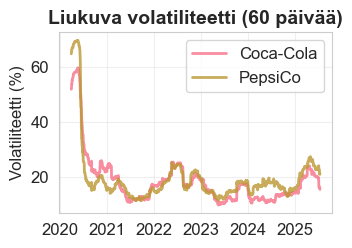

In [22]:
# 4. Volatiliteetin vertailu (rolling 60-päivää)
plt.figure(figsize=(12, 8))
ax4 = plt.subplot(3, 3, 4)
for ticker in stock_data.columns:
    rolling_vol = stock_data[ticker].pct_change().rolling(60).std() * np.sqrt(252) * 100
    ax4.plot(rolling_vol.index, rolling_vol, linewidth=2, 
             label=f"{company_names[ticker]}", alpha=0.8)

ax4.set_title('Liukuva volatiliteetti (60 päivää)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Volatiliteetti (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

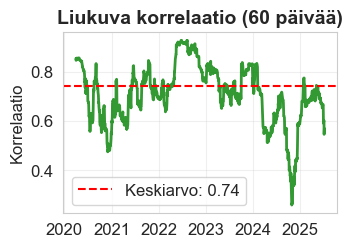

In [23]:
# 5. Korrelaation kehitys
plt.figure(figsize=(12, 8))
ax5 = plt.subplot(3, 3, 5)
rolling_corr = correlation_data['rolling_correlation']
ax5.plot(rolling_corr.index, rolling_corr, linewidth=2, color='green', alpha=0.8)
ax5.axhline(y=correlation_data['correlation'], color='red', linestyle='--', 
           label=f"Keskiarvo: {correlation_data['correlation']:.2f}")
ax5.set_title('Liukuva korrelaatio (60 päivää)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Korrelaatio')
ax5.legend()
ax5.grid(True, alpha=0.3)

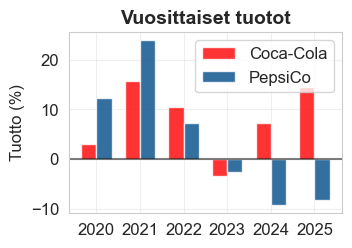

In [24]:
# 6. Vuosittaiset tuotot
plt.figure(figsize=(12, 8))
ax6 = plt.subplot(3, 3, 6)
years = range(2020, datetime.now().year + 1)
annual_returns = {ticker: [] for ticker in stock_data.columns}

for year in years:
    year_data = stock_data[stock_data.index.year == year]
    if len(year_data) > 0:
        for ticker in stock_data.columns:
            year_return = (year_data[ticker].iloc[-1] / year_data[ticker].iloc[0] - 1) * 100
            annual_returns[ticker].append(year_return)

x = np.arange(len(years))
width = 0.35

for i, ticker in enumerate(stock_data.columns):
    ax6.bar(x + i*width, annual_returns[ticker], width, 
           label=company_names[ticker], alpha=0.8, color=colors[i])

ax6.set_title('Vuosittaiset tuotot', fontsize=14, fontweight='bold')
ax6.set_ylabel('Tuotto (%)')
ax6.set_xticks(x + width/2)
ax6.set_xticklabels([str(y) for y in years])
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)

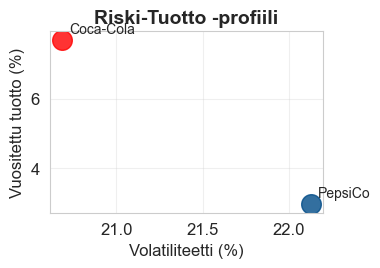

In [25]:
# 7. Risk-Return scatter
plt.figure(figsize=(12, 8))
ax7 = plt.subplot(3, 3, 7)
for i, ticker in enumerate(stock_data.columns):
    ax7.scatter(metrics[ticker]['volatility'], metrics[ticker]['annualized_return'], 
               s=200, color=colors[i], alpha=0.8, 
               label=f"{company_names[ticker]}")
    
    # Lisää tekstit
    ax7.annotate(company_names[ticker], 
                (metrics[ticker]['volatility'], metrics[ticker]['annualized_return']),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax7.set_xlabel('Volatiliteetti (%)')
ax7.set_ylabel('Vuositettu tuotto (%)')
ax7.set_title('Riski-Tuotto -profiili', fontsize=14, fontweight='bold')
ax7.grid(True, alpha=0.3)

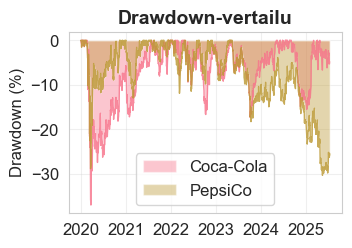

In [26]:
# 8. Drawdown-vertailu
plt.figure(figsize=(12, 8))
ax8 = plt.subplot(3, 3, 8)
for ticker in stock_data.columns:
    cummax = stock_data[ticker].expanding().max()
    drawdown = (stock_data[ticker] / cummax - 1) * 100
    ax8.fill_between(drawdown.index, drawdown, 0, alpha=0.4, 
                    label=f"{company_names[ticker]}")
    ax8.plot(drawdown.index, drawdown, linewidth=1, alpha=0.8)

ax8.set_title('Drawdown-vertailu', fontsize=14, fontweight='bold')
ax8.set_ylabel('Drawdown (%)')
ax8.legend()
ax8.grid(True, alpha=0.3)

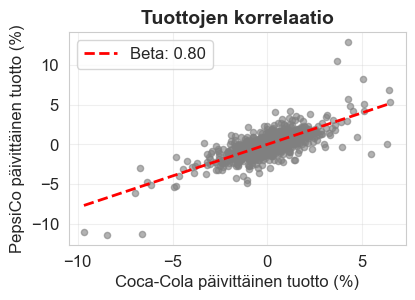

In [27]:
# 9. Tuottojen scatter plot
plt.figure(figsize=(12, 8))
ax9 = plt.subplot(3, 3, 9)
ko_returns = stock_data['KO'].pct_change().dropna() * 100
pep_returns = stock_data['PEP'].pct_change().dropna() * 100

ax9.scatter(ko_returns, pep_returns, alpha=0.6, s=20, color='gray')

# Regressiosuora
z = np.polyfit(ko_returns, pep_returns, 1)
p = np.poly1d(z)
x_line = np.linspace(ko_returns.min(), ko_returns.max(), 100)
ax9.plot(x_line, p(x_line), "r--", linewidth=2, 
         label=f'Beta: {correlation_data["beta_pep_vs_ko"]:.2f}')

ax9.set_xlabel('Coca-Cola päivittäinen tuotto (%)')
ax9.set_ylabel('PepsiCo päivittäinen tuotto (%)')
ax9.set_title('Tuottojen korrelaatio', fontsize=14, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# 4. SYVEMPI ANALYYSI
print(f"\n📊 4. KILPAILIJA-ANALYYSI")
print("-" * 50)

# Määritä voittaja eri kategorioissa
categories = {
    'Kokonaistuotto': 'total_return',
    'Riski-adjusted tuotto (Sharpe)': 'sharpe',
    'Riskinhallinta (max drawdown)': 'max_drawdown',
    'Johdonmukaisuus (win rate)': 'win_rate',
    'Volatiliteetti (matala parempi)': 'volatility'
}

print("KATEGORIA-ANALYYSI:")
for category, metric in categories.items():
    ko_value = metrics['KO'][metric]
    pep_value = metrics['PEP'][metric]
    
    if metric == 'max_drawdown' or metric == 'volatility':
        # Pienempi arvo on parempi
        winner = 'Coca-Cola' if ko_value > pep_value else 'PepsiCo'
        better_value = max(ko_value, pep_value)
        worse_value = min(ko_value, pep_value)
    else:
        # Suurempi arvo on parempi
        winner = 'Coca-Cola' if ko_value > pep_value else 'PepsiCo'
        better_value = max(ko_value, pep_value)
        worse_value = min(ko_value, pep_value)
    
    print(f"• {category}: {winner} voittaa")
    print(f"  KO: {ko_value:.2f} | PEP: {pep_value:.2f}")

# Kokonaispisteytys
ko_wins = sum([
    metrics['KO']['total_return'] > metrics['PEP']['total_return'],
    metrics['KO']['sharpe'] > metrics['PEP']['sharpe'],
    metrics['KO']['max_drawdown'] > metrics['PEP']['max_drawdown'],  # Vähemmän negatiivinen
    metrics['KO']['win_rate'] > metrics['PEP']['win_rate'],
    metrics['KO']['volatility'] < metrics['PEP']['volatility']  # Vähemmän volatiliteetti
])

pep_wins = 5 - ko_wins

print(f"\nKOKONAISPISTEYTYS:")
print(f"• Coca-Cola voittaa: {ko_wins}/5 kategoriassa")
print(f"• PepsiCo voittaa: {pep_wins}/5 kategoriassa")

overall_winner = "Coca-Cola" if ko_wins > pep_wins else "PepsiCo" if pep_wins > ko_wins else "Tasapeli"
print(f"• Kokonaisvoittaja: {overall_winner}")


📊 4. KILPAILIJA-ANALYYSI
--------------------------------------------------
KATEGORIA-ANALYYSI:
• Kokonaistuotto: Coca-Cola voittaa
  KO: 50.52 | PEP: 17.27
• Riski-adjusted tuotto (Sharpe): Coca-Cola voittaa
  KO: 0.28 | PEP: 0.04
• Riskinhallinta (max drawdown): PepsiCo voittaa
  KO: -36.99 | PEP: -30.32
• Johdonmukaisuus (win rate): Coca-Cola voittaa
  KO: 53.35 | PEP: 52.85
• Volatiliteetti (matala parempi): PepsiCo voittaa
  KO: 20.68 | PEP: 22.13

KOKONAISPISTEYTYS:
• Coca-Cola voittaa: 4/5 kategoriassa
• PepsiCo voittaa: 1/5 kategoriassa
• Kokonaisvoittaja: Coca-Cola


In [18]:
# 5. SIJOITUSANALYYSI
print(f"\n💰 5. SIJOITUSANALYYSI")
print("-" * 50)

investment_amount = 10000
print(f"SIJOITUSSKENAARIO (${investment_amount:,} kumpaankin 1.1.2020):")

for ticker in stock_data.columns:
    final_value = investment_amount * (1 + metrics[ticker]['total_return']/100)
    profit = final_value - investment_amount
    
    print(f"\n{company_names[ticker]} ({ticker}):")
    print(f"  Lopullinen arvo: ${final_value:,.0f}")
    print(f"  Voitto/tappio: ${profit:+,.0f} ({metrics[ticker]['total_return']:+.1f}%)")

# Portfolio-analyysi (50/50 jakauma)
portfolio_value = investment_amount * (
    0.5 * (1 + metrics['KO']['total_return']/100) + 
    0.5 * (1 + metrics['PEP']['total_return']/100)
)
portfolio_return = (portfolio_value / investment_amount - 1) * 100

print(f"\n50/50 PORTFOLIO:")
print(f"  Lopullinen arvo: ${portfolio_value:,.0f}")
print(f"  Tuotto: {portfolio_return:+.1f}%")

# Diversifikaation hyöty
individual_avg_vol = (metrics['KO']['volatility'] + metrics['PEP']['volatility']) / 2
portfolio_vol = np.sqrt(
    0.25 * metrics['KO']['volatility']**2 + 
    0.25 * metrics['PEP']['volatility']**2 + 
    0.5 * correlation_data['correlation'] * metrics['KO']['volatility'] * metrics['PEP']['volatility']
)

print(f"\nDIVERSIFIKAATION HYÖTY:")
print(f"  Yksittäisten osakkeiden keskivol: {individual_avg_vol:.1f}%")
print(f"  50/50 portfolion volatiliteetti: {portfolio_vol:.1f}%")
print(f"  Riskin vähennys: {individual_avg_vol - portfolio_vol:.1f} prosenttiyksikköä")


💰 5. SIJOITUSANALYYSI
--------------------------------------------------
SIJOITUSSKENAARIO ($10,000 kumpaankin 1.1.2020):

Coca-Cola (KO):
  Lopullinen arvo: $15,052
  Voitto/tappio: $+5,052 (+50.5%)

PepsiCo (PEP):
  Lopullinen arvo: $11,727
  Voitto/tappio: $+1,727 (+17.3%)

50/50 PORTFOLIO:
  Lopullinen arvo: $13,390
  Tuotto: +33.9%

DIVERSIFIKAATION HYÖTY:
  Yksittäisten osakkeiden keskivol: 21.4%
  50/50 portfolion volatiliteetti: 20.0%
  Riskin vähennys: 1.4 prosenttiyksikköä


In [19]:
# 6. STRATEGISET JOHTOPÄÄTÖKSET
print(f"\n🎯 6. STRATEGISET JOHTOPÄÄTÖKSET")
print("-" * 50)

print("KESKEISTÄ HAVAINNOT:")
print(f"• Korrelaatio {correlation_data['correlation']:.2f} - vahva positiivinen suhde")
print(f"• Molemmat ovat defensive-osakkeita (matala volatiliteetti)")
print(f"• Diversifikaation hyöty rajallinen korkean korrelaation vuoksi")

print(f"\nLIIKETOIMINTA-ANALYYSI:")
if metrics['PEP']['total_return'] > metrics['KO']['total_return']:
    print("• PepsiCo:n laajempi portfoli (snacksit) näyttää tuottaneen lisäarvoa")
else:
    print("• Coca-Colan fokus juomiin on osoittautunut tehokkaaksi")

print("• Molemmat hyötyivät kotona kuluttamisesta COVID-19 aikana")
print("• Inflaatiopaineet vaikuttivat molempiin samankaltaisesti")

print(f"\nSIJOITUSSTRATEGIAN SUOSITUKSET:")
print("• Valitse yksi yhtiö sijaan molempien omistamista")
print("• PepsiCo tarjoaa paremman diversifikaation (elintarvikkeet)")
print("• Coca-Cola puhtaampi juoma-altistus")
print("• Molemmat sopivia dividend growth -strategiaan")


🎯 6. STRATEGISET JOHTOPÄÄTÖKSET
--------------------------------------------------
KESKEISTÄ HAVAINNOT:
• Korrelaatio 0.74 - vahva positiivinen suhde
• Molemmat ovat defensive-osakkeita (matala volatiliteetti)
• Diversifikaation hyöty rajallinen korkean korrelaation vuoksi

LIIKETOIMINTA-ANALYYSI:
• Coca-Colan fokus juomiin on osoittautunut tehokkaaksi
• Molemmat hyötyivät kotona kuluttamisesta COVID-19 aikana
• Inflaatiopaineet vaikuttivat molempiin samankaltaisesti

SIJOITUSSTRATEGIAN SUOSITUKSET:
• Valitse yksi yhtiö sijaan molempien omistamista
• PepsiCo tarjoaa paremman diversifikaation (elintarvikkeet)
• Coca-Cola puhtaampi juoma-altistus
• Molemmat sopivia dividend growth -strategiaan
